### **homework 3: convolutional neural network**

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.

There are three levels here:

- **Easy**: Build a simple convolutional neural network as the baseline.

- **Medium**: Design a better architecture or adopt different data augmentations to improve the performance.

- **Hard**: Utilize provided unlabeled data to obtain better results.

### **about the dataset**

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data.<br>
Please DO NOT access the original fully-labeled training data or testing labels.

download data from [kaggle](https://www.kaggle.com/competitions/ml2021spring-hw3/data) <br>

### **import packages**

First, we need to import packages that will be used later.<br>
In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
# import necessary packages

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# this is for the progress bar
from tqdm.auto import tqdm

### **some utilities**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

def plot_learning_curve(record, title='', mode='acc'):
  ''' plot learning curve of your DNN (train & validation loss/acc) '''
  
  if mode == 'acc':
    total_steps = len(record['train_acc'])
  else:
    total_steps = len(record['train_loss'])

  epochs = range(total_steps)
  
  figure(figsize=(5, 3))
  plt.xlabel('epoch')
  
  if mode == 'acc':
    plt.plot(epochs, record['train_acc'], c='tab:orange', label='train acc', linestyle='--')
    plt.plot(epochs, record['valid_acc'], c='tab:blue', label='valid acc', linestyle='--')
    plt.ylabel('accuracy')
  else:  
    plt.plot(epochs, record['train_loss'], c='tab:red', label='train loss', linestyle='--')
    plt.plot(epochs, record['valid_loss'], c='tab:cyan', label='valid loss', linestyle='--')
    plt.ylabel('loss')
  
  plt.title(f'{mode} curve of {title}')
  # use MaxNLocator to automatically adjust the x-axis ticks
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

  plt.legend()
  plt.show()

### **dataset, data Loader, and transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [ ]:
# it is important to do data augmentation in training
# however, not every augmentation is useful
# please think about what kind of augmentation is helpful for food recognition
train_tfm = transforms.Compose([
    # resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # you may add some transforms here
    # ToTensor() should be the last one of the transforms
    transforms.ToTensor(),
])

# we don't need augmentations in testing and validation
# all we need here is to resize the PIL image and transform it into Tensor
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
# batch size for training, validation, and testing
# a greater batch size usually gives a more stable gradient
# but the GPU memory is limited, so please adjust it carefully
batch_size = 128

# construct datasets.
# the argument "loader" tells how torchvision reads the data
train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# construct data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

### **model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

#### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    # the arguments for commonly used modules:
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    # torch.nn.MaxPool2d(kernel_size, stride, padding)

    # input image size: [3, 128, 128]
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
    )
    self.fc_layers = nn.Sequential(
        nn.Linear(256 * 8 * 8, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 11)
    )

  def forward(self, x):
    # input (x): [batch_size, 3, 128, 128]
    # output: [batch_size, 11]

    # extract features by convolutional layers
    x = self.cnn_layers(x)

    # the extracted feature map must be flatten before going to fully-connected layers
    x = x.flatten(1)

    # the features are transformed by fully-connected layers to obtain the final logits
    x = self.fc_layers(x)
    return x


### **training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [ ]:
def get_pseudo_labels(dataset, model, threshold=0.65):
  # this functions generates pseudo-labels of a dataset using given model
  # it returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold
  # you are NOT allowed to use any models trained on external data for pseudo-labeling
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # construct a data loader
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  # make sure the model is in eval mode
  model.eval()
  # define softmax function
  softmax = nn.Softmax(dim=-1)

  # iterate over the dataset by batches
  for batch in tqdm(data_loader):
    img, _ = batch

    # forward the data
    # using torch.no_grad() accelerates the forward process
    with torch.no_grad():
      logits = model(img.to(device))

    # obtain the probability distributions by applying softmax on logits
    probs = softmax(logits)

    # ---------- TODO ----------
    # filter the data and construct a new dataset

  # turn off the eval mode
  model.train()
  return dataset

In [ ]:
# "cuda" only when GPUs are available
device = "cuda" if torch.cuda.is_available() else "cpu"

# initialize a model, and put it on the device specified
model = Classifier().to(device)
model.device = device

# for the classification task, we use cross-entropy as the measurement of performance
criterion = nn.CrossEntropyLoss()

# initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# the number of training epochs.
n_epochs = 80

# whether to do semi-supervised learning.
do_semi = False

loss_acc_record = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}  # for recording loss/acc

for epoch in range(n_epochs):
  # ---------- TODO ----------
  # in each epoch, relabel the unlabeled dataset for semi-supervised learning
  # then you can combine the labeled dataset and pseudo-labeled dataset for the training
  
  if do_semi:
    # obtain pseudo-labels for unlabeled data using trained model
    pseudo_set = get_pseudo_labels(unlabeled_set, model)

    # construct a new dataset and a data loader for training
    # this is used in semi-supervised learning only
    concat_dataset = ConcatDataset([train_set, pseudo_set])
    train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

  # ---------- training ----------
  # make sure the model is in train mode before training
  model.train()

  # these are used to record information in training
  train_loss = []
  train_accs = []

  # iterate the training set by batches
  for batch in tqdm(train_loader):
  # for batch in train_loader:

    # a batch consists of image data and corresponding labels
    imgs, labels = batch

    # forward the data. (make sure data and model are on the same device)
    logits = model(imgs.to(device))

    # calculate the cross-entropy loss
    # we don't need to apply softmax before computing cross-entropy as it is done automatically
    loss = criterion(logits, labels.to(device))

    # gradients stored in the parameters in the previous step should be cleared out first
    optimizer.zero_grad()

    # compute the gradients for parameters
    loss.backward()

    # clip the gradient norms for stable training
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

    # update the parameters with computed gradients
    optimizer.step()

    # compute the accuracy for current batch
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # record the loss and accuracy
    train_loss.append(loss.item())
    train_accs.append(acc)

  # the average loss and accuracy of the training set is the average of the recorded values
  train_loss = sum(train_loss) / len(train_loss)
  train_acc = sum(train_accs) / len(train_accs)

  loss_acc_record['train_loss'].append(train_loss)
  loss_acc_record['train_acc'].append(train_acc)

  # print the information
  print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

  # ---------- validation ----------
  # make sure the model is in eval mode so that some modules like dropout are disabled and work normally
  model.eval()

  # these are used to record information in validation
  valid_loss = []
  valid_accs = []

  # iterate the validation set by batches
  for batch in tqdm(valid_loader):
    # a batch consists of image data and corresponding labels
    imgs, labels = batch

    # we don't need gradient in validation.
    # using torch.no_grad() accelerates the forward process
    with torch.no_grad():
      logits = model(imgs.to(device))

    # we can still compute the loss (but not the gradient)
    loss = criterion(logits, labels.to(device))

    # compute the accuracy for current batch
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # record the loss and accuracy
    valid_loss.append(loss.item())
    valid_accs.append(acc)

  # the average loss and accuracy for entire validation set is the average of the recorded values
  valid_loss = sum(valid_loss) / len(valid_loss)
  valid_acc = sum(valid_accs) / len(valid_accs)

  loss_acc_record['valid_loss'].append(valid_loss)
  loss_acc_record['valid_acc'].append(valid_acc)

  # print the information.
  print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


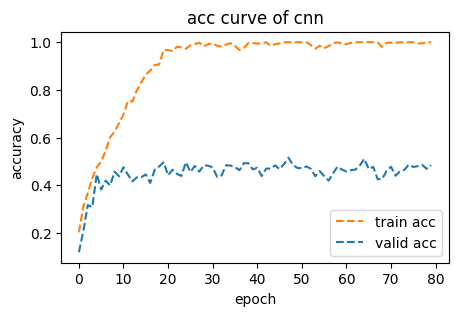

In [39]:
plot_learning_curve(loss_acc_record, title='cnn', mode='acc') # plot acc curve

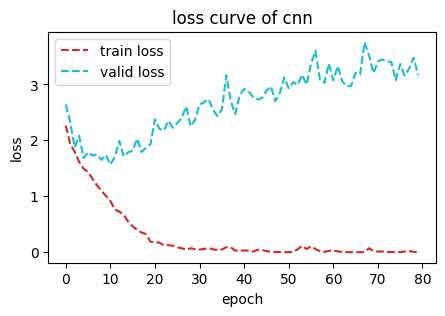

In [40]:
plot_learning_curve(loss_acc_record, title='cnn', mode='loss') # plot loss curve

### **testing**

For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

In [ ]:
# make sure the model is in eval mode
# some modules like Dropout or BatchNorm affect if the model is in training mode
model.eval()

# initialize a list to store the predictions
predictions = []

# iterate the testing set by batches
for batch in tqdm(test_loader):
  # a batch consists of image data and corresponding labels
  # but here the variable "labels" is useless since we do not have the ground-truth
  # if printing out the labels, you will find that it is always 0
  # this is because the wrapper (DatasetFolder) returns images and labels for each batch
  # so we have to create fake labels to make it work normally
  imgs, labels = batch

  # we don't need gradient in testing, and we don't even have labels to compute loss
  # using torch.no_grad() accelerates the forward process
  with torch.no_grad():
    logits = model(imgs.to(device))

  # take the class with greatest logit as prediction and record it
  predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [ ]:
# save predictions into the file
with open("predict.csv", "w") as f:

  # the first row must be "Id, Category"
  f.write("Id,Category\n")

  # for the rest of the rows, each image id corresponds to a predicted class
  for i, pred in enumerate(predictions):
    f.write(f"{i},{pred}\n")
  
  print("done!")